# **1. Cài đặt Vnstock**



In [ ]:
!pip install vnstock==0.2.9.0 #Cài đặt thư viện Vnstock phiên bản 0.2.9.0
!pip install backtrader #Cài đặt thư viện Backtrader
!pip install PyPortfolioOpt
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.9 MB/s eta 0:00:00


# **2. Cài đặt thư viện**

In [ ]:
from datetime import datetime #import thư viện datetime để làm việc với ngày và giờ
import backtrader as bt #import thư viện Backtrader để phân tích và backtesting chiến lược giao dịch
import matplotlib.pyplot as plt #import matplotlib.pyplot để vẽ và hiển thị biểu đồ
import numpy as np #import thư viện NumPy để thực hiện các phép tính số học và xử lý mảng
import pandas as pd #import thư viện Pandas để xử lý dữ liệu dạng bảng (DataFrame)
from IPython.display import Image #import hàm Image để hiển thị hình ảnh trong Jupyter Notebook
import IPython #import thư viện IPython để cải thiện trải nghiệm trong môi trường tương tác
from vnstock import * #import tất cả các hàm từ thư viện vnstock để lấy dữ liệu chứng khoán Việt Nam
import math
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from itertools import combinations
from tabulate import tabulate
from openpyxl import Workbook
from itertools import combinations
from scipy.optimize import minimize
import seaborn as sns

# **3. Lọc ra các mã công ty niêm**

In [ ]:
# Lấy danh sách các công ty niêm yết
list0 = listing_companies()
print('Danh sách các công ty được niêm yết:')
print(list0)
# Lọc ra danh sách mã chứng khoán trong VN30
print('\nDanh sách mã chứng khoán trong VN30:')
listVN30 = list0[list0['VN30'] == True].ticker.to_list()
print(listVN30)

Danh sách các công ty được niêm yết:
     ticker comGroupCode                                          organName  \
0       SSI         HOSE                    Công ty Cổ phần Chứng khoán SSI   
1       BCM         HOSE  Tổng Công ty Đầu tư và Phát triển Công nghiệp ...   
2       VHM         HOSE                           Công ty Cổ phần Vinhomes   
3       VIC         HOSE                     Tập đoàn Vingroup - Công ty CP   
4       VRE         HOSE                      Công ty Cổ phần Vincom Retail   
...     ...          ...                                                ...   
1602    SDK        UPCOM                   Công ty Cổ phần Cơ khí Luyện Kim   
1603    SRF         HOSE                          Công ty Cổ phần Searefico   
1604    UEM        UPCOM        Công ty Cổ phần Cơ điện Uông Bí - Vinacomin   
1605    VEA        UPCOM  Tổng Công ty Máy động lực và Máy nông nghiệp V...   
1606    VES        UPCOM  Công ty Cổ phần Đầu tư và Xây dựng Điện MÊ CA ...   

              

# **4. Lấy dữ liệu thực hành trên colab**

In [ ]:
# Danh sách mã cổ phiếu
tickers = ['HPG','FPT', 'VCB', 'VNM', 'PNJ']
start_date = '2020-01-01'
end_date = '2025-02-28'

# Khởi tạo DataFrame chứa giá đóng cửa đầu mỗi tháng
monthly_close_df = pd.DataFrame()

# Tải và xử lý dữ liệu
for ticker in tickers:
    # Lấy dữ liệu lịch sử theo ngày
    df = stock_historical_data(ticker, start_date, end_date, resolution='1D')
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

    # Lấy giá đóng cửa ngày giao dịch đầu tiên mỗi tháng
    monthly_first = df.resample('MS').first()  # 'MS' = Month Start
    monthly_close_df[ticker] = monthly_first['close']

# Hiển thị bảng giá đóng cửa đầu tháng
print(f" Bảng giá đóng cửa vào ngày giao dịch đầu tiên mỗi tháng {start_date} đến {end_date}:")
display(monthly_close_df)


 Bảng giá đóng cửa vào ngày giao dịch đầu tiên mỗi tháng 2020-01-01 đến 2025-02-28:


,HPG,FPT,VCB,VNM,PNJ
time,,,,,
2020-01-01,9940,24830,39510,78050,58380
2020-02-01,10160,21820,38600,71690,55320
2020-03-01,9240,23600,35590,69180,54520
2020-04-01,7150,17920,28280,62220,33190
2020-05-01,8690,21400,29320,64599,38560
...,...,...,...,...,...
2024-10-01,26750,134960,61540,69560,96410
2024-11-01,26550,133670,62540,65290,90840
2024-12-01,26900,142200,63010,64000,93430


# **5. Vẽ biểu đồ**

## 5.1. Vẽ biểu đồ giá đóng cửa

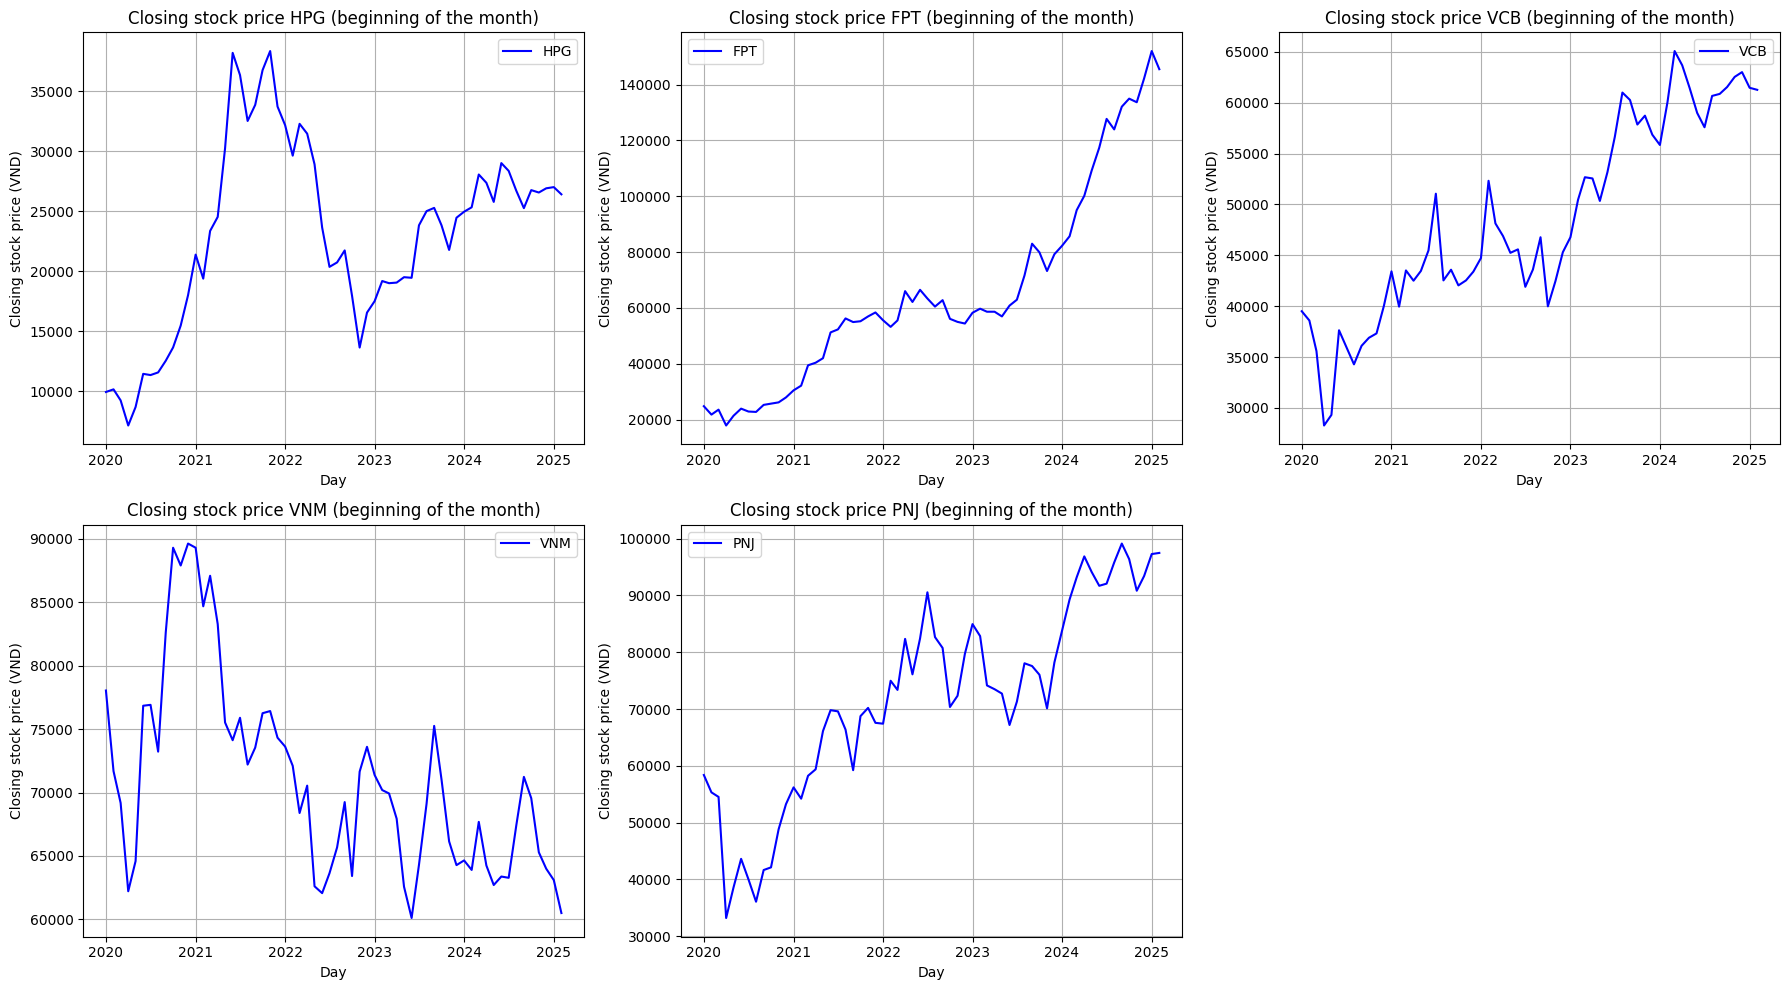

In [ ]:
# Thiết lập lưới vẽ: 3 biểu đồ mỗi hàng
num_stocks = len(tickers)
cols = 3
rows = math.ceil(num_stocks / cols)

# Tạo figure và axes
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()  # Chuyển axes thành list 1 chiều

# Vẽ biểu đồ cho từng cổ phiếu
for i, stock_code in enumerate(tickers):
    data1 = monthly_close_df[[stock_code]].dropna()
    axes[i].plot(data1.index, data1[stock_code], label=stock_code, color='blue')
    axes[i].set_title(f'Closing stock price {stock_code} (beginning of the month)', fontsize=12)
    axes[i].set_xlabel('Day')
    axes[i].set_ylabel('Closing stock price (VND)')
    axes[i].legend()
    axes[i].grid(True)

# Ẩn các subplot dư nếu có
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 5.2. Vẽ biểu đồ biến động giá so với tháng trước

Price change (% change from previous month)):


,HPG,FPT,VCB,VNM,PNJ
time,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN
2020-02-01,2.213280,-12.122433,-2.303214,-8.148623,-5.241521
2020-03-01,-9.055118,8.157654,-7.797927,-3.501186,-1.446132
2020-04-01,-22.619048,-24.067797,-20.539477,-10.060711,-39.123258
2020-05-01,21.538462,19.419643,3.677511,3.823529,16.179572
...,...,...,...,...,...
2024-10-01,5.940594,2.180497,1.100706,-2.358226,-2.763490
2024-11-01,-0.747664,-0.955839,1.624959,-6.138585,-5.777409
2024-12-01,1.318267,6.381387,0.751519,-1.975800,2.851167


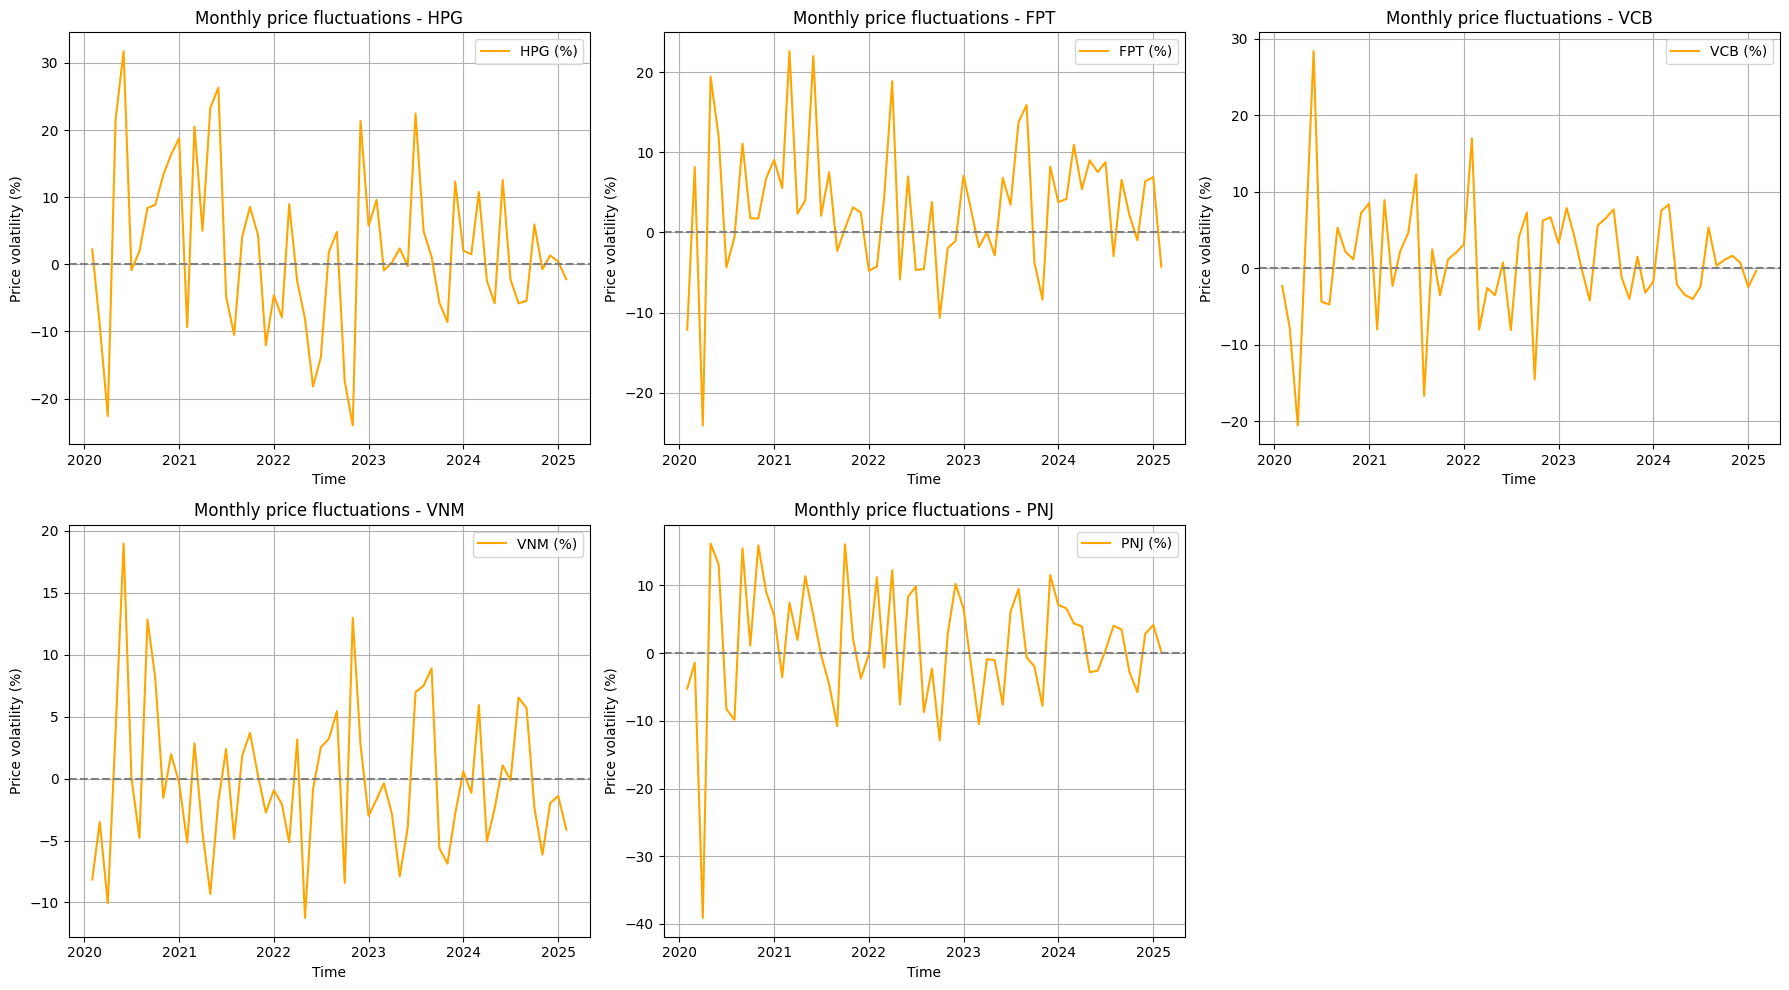

In [ ]:
# Tính phần trăm biến động giá mỗi tháng (%)
monthly_pct_change = monthly_close_df.pct_change() * 100  # nhân 100 để ra %

print("Price change (% change from previous month)):")
display(monthly_pct_change)

# Vẽ biểu đồ biến động giá
num_stocks = len(tickers)
cols = 3
rows = math.ceil(num_stocks / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, stock_code in enumerate(tickers):
    data_pct = monthly_pct_change[[stock_code]].dropna()
    axes[i].plot(data_pct.index, data_pct[stock_code], label=f'{stock_code} (%)', color='orange')
    axes[i].axhline(0, color='gray', linestyle='--')  # Đường mốc 0%
    axes[i].set_title(f'Monthly price fluctuations - {stock_code}', fontsize=12)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Price volatility (%)')
    axes[i].legend()
    axes[i].grid(True)

# Ẩn các subplot dư
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **6. Tính hệ số Sharpe**

## 6.1. Tính Expected Return, Variance, Std Dev

 BẢNG 1: Expected Return, Variance, Std Dev
                       HPG   FPT   VCB   VNM   PNJ
Expected Return (%)   2.28  3.27  1.00 -0.25  1.29
Variance (%²)         1.37  0.66  0.55  0.34  0.81
Std Dev (%)          11.69  8.12  7.43  5.80  9.01

 BẢNG 2: Covariance Matrix
          HPG       FPT       VCB       VNM       PNJ
HPG  0.013657  0.004934  0.004436  0.002083  0.005364
FPT  0.004934  0.006590  0.002056  0.002019  0.004457
VCB  0.004436  0.002056  0.005514  0.002544  0.003330
VNM  0.002083  0.002019  0.002544  0.003359  0.002487
PNJ  0.005364  0.004457  0.003330  0.002487  0.008126

 BẢNG 3: Correlation Matrix
        HPG     FPT     VCB     VNM     PNJ
HPG  1.0000  0.5200  0.5112  0.3075  0.5092
FPT  0.5200  1.0000  0.3411  0.4292  0.6091
VCB  0.5112  0.3411  1.0000  0.5912  0.4974
VNM  0.3075  0.4292  0.5912  1.0000  0.4760
PNJ  0.5092  0.6091  0.4974  0.4760  1.0000

 Đã lưu kết quả vào file: stock_statistics.xlsx


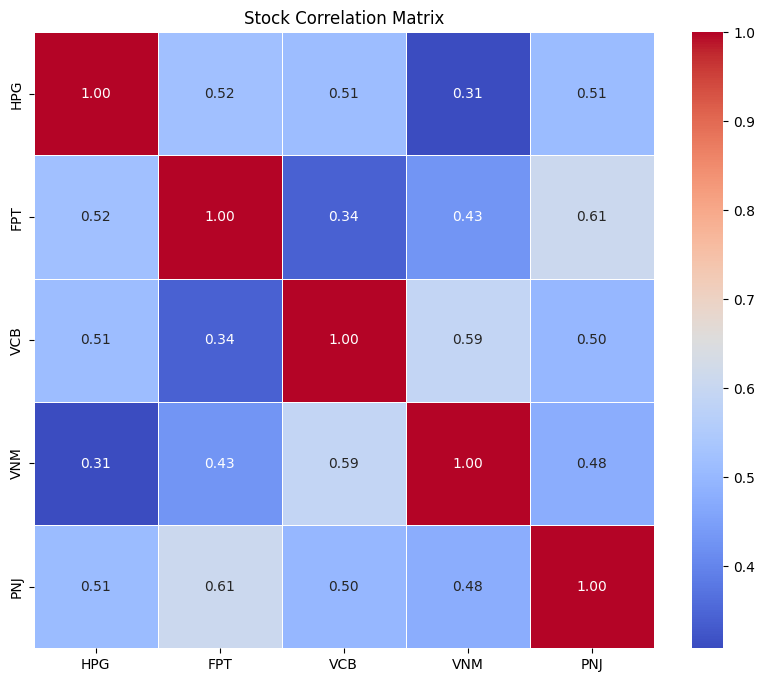

In [ ]:
# Lọc dữ liệu các cổ phiếu
selected = monthly_close_df[tickers]

# Tính lợi suất hàng tháng
returns = selected.pct_change().dropna()

# 1. Expected Return, Variance, Std Dev (theo toàn bộ quần thể - VAR.P, STDEV.P)
expected_return = returns.mean()
variance = returns.var(ddof=0)  # VAR.P
std_dev = returns.std(ddof=0)   # STDEV.P

# Chuyển đổi sang phần trăm và làm tròn
summary_df = pd.DataFrame({
    'Expected Return (%)': expected_return * 100,
    'Variance (%²)': variance * 100,   # giữ đúng đơn vị %² nếu bạn đang nhân 100
    'Std Dev (%)': std_dev * 100
}).T.round(2)

# 2. Covariance matrix (giữ nguyên)
cov_matrix = returns.cov(ddof=0).round(6)

# 3. Correlation matrix (không bị ảnh hưởng bởi ddof)
corr_matrix = returns.corr().round(4)

# In ra 3 bảng
print(" BẢNG 1: Expected Return, Variance, Std Dev")
print(summary_df)

print("\n BẢNG 2: Covariance Matrix")
print(cov_matrix)

print("\n BẢNG 3: Correlation Matrix")
print(corr_matrix)

# Ghi ra file Excel với 3 sheet
with pd.ExcelWriter("stock_statistics.xlsx") as writer:
    summary_df.to_excel(writer, sheet_name="Summary")
    cov_matrix.to_excel(writer, sheet_name="Covariance")
    corr_matrix.to_excel(writer, sheet_name="Correlation")

print("\n Đã lưu kết quả vào file: stock_statistics.xlsx")

# Vẽ biểu đồ tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Stock Correlation Matrix")
plt.show()

## 6.2. Tính Sharpe ratio

In [ ]:
# Tính lợi suất và ma trận hiệp phương sai
returns = monthly_close_df[tickers].pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
rf = 0.09/12  # Lãi suất phi rủi ro hàng tháng

results = []

# Hàm tối ưu: âm Sharpe ratio
def negative_sharpe(weights, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (portfolio_return - rf) / portfolio_std if portfolio_std != 0 else np.inf

# Tối ưu cho từng tổ hợp 3 cổ phiếu
for combo in combinations(tickers, 3):
    assets = list(combo)
    mu = mean_returns[assets]
    cov = cov_matrix.loc[assets, assets]

    init_guess = [1/3, 1/3, 1/3]
    bounds = [(0.05, 0.4)] * 3  # Ràng buộc tỷ trọng tối thiểu 5%
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    opt = minimize(negative_sharpe, init_guess, args=(mu, cov, rf), method='SLSQP',
                   bounds=bounds, constraints=constraints)

    if opt.success:
        weights = opt.x
        wi, wj, wk = weights
        eri, erj, erk = mu[assets[0]], mu[assets[1]], mu[assets[2]]
        si, sj, sk = returns[assets[0]].std(), returns[assets[1]].std(), returns[assets[2]].std()
        cov_ij = cov_matrix.loc[assets[0], assets[1]]
        cov_ik = cov_matrix.loc[assets[0], assets[2]]
        cov_jk = cov_matrix.loc[assets[1], assets[2]]

        erp = np.dot(weights, mu)
        std_p = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        sharpe = (erp - rf) / std_p if std_p != 0 else np.nan

        results.append({
            'Stock i': assets[0], 'Stock j': assets[1], 'Stock k': assets[2],
            'wi': wi, 'wj': wj, 'wk': wk,
            'E(ri)': eri, 'E(rj)': erj, 'E(rk)': erk,
            'σi': si, 'σj': sj, 'σk': sk,
            'Cov(ij)': cov_ij, 'Cov(ik)': cov_ik, 'Cov(jk)': cov_jk,
            'E(rp)': erp, 'σp': std_p, 'Sharpe ratio': sharpe
        })

# Tạo DataFrame
results_df = pd.DataFrame(results)
results_df.index += 1
results_df.insert(0, 'No.', results_df.index)

# Format %
cols_pct = ['wi', 'wj', 'wk', 'E(ri)', 'E(rj)', 'E(rk)',
            'σi', 'σj', 'σk', 'Cov(ij)', 'Cov(ik)', 'Cov(jk)',
            'E(rp)', 'σp', 'Sharpe ratio']
results_df[cols_pct] = results_df[cols_pct].applymap(lambda x: f"{x*100:.4f}%" if isinstance(x, float) else x)

# Sắp xếp theo Sharpe ratio giảm dần
results_df['Sharpe ratio (raw)'] = results_df['Sharpe ratio'].str.replace('%', '').astype(float)
results_df = results_df.sort_values(by='Sharpe ratio (raw)', ascending=False)
results_df.drop(columns=['Sharpe ratio (raw)'], inplace=True)

# In bảng
print("Optimal portfolio according to Sharpe:")
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid'))

Optimal portfolio according to Sharpe:
╒════╤═══════╤═══════════╤═══════════╤═══════════╤══════════╤══════════╤══════════╤═════════╤══════════╤══════════╤══════════╤═════════╤═════════╤═══════════╤═══════════╤═══════════╤═════════╤═════════╤════════════════╕
│    │   No. │ Stock i   │ Stock j   │ Stock k   │ wi       │ wj       │ wk       │ E(ri)   │ E(rj)    │ E(rk)    │ σi       │ σj      │ σk      │ Cov(ij)   │ Cov(ik)   │ Cov(jk)   │ E(rp)   │ σp      │ Sharpe ratio   │
╞════╪═══════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╪══════════╪═════════╪══════════╪══════════╪══════════╪═════════╪═════════╪═══════════╪═══════════╪═══════════╪═════════╪═════════╪════════════════╡
│  1 │     1 │ HPG       │ FPT       │ VCB       │ 40.0000% │ 40.0000% │ 20.0000% │ 2.2816% │ 3.2672%  │ 0.9952%  │ 11.7831% │ 8.1854% │ 7.4873% │ 0.5016%   │ 0.4510%   │ 0.2091%   │ 2.4186% │ 7.8606% │ 21.2270%       │
├────┼───────┼───────────┼───────────┼───────────┼──────────┼──────────┼─────────

<ipython-input-8-360d1f423118>:59: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df[cols_pct] = results_df[cols_pct].applymap(lambda x: f"{x*100:.4f}%" if isinstance(x, float) else x)


In [ ]:
# Tính lợi suất và ma trận hiệp phương sai
returns = monthly_close_df[tickers].pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
rf = 0.09 / 12  # Lãi suất phi rủi ro hàng tháng

# Danh sách kết quả
results = []

# Hàm tối ưu: âm Sharpe ratio
def negative_sharpe(weights, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (portfolio_return - rf) / portfolio_std if portfolio_std != 0 else np.inf

# Tối ưu cho từng tổ hợp 3 cổ phiếu
k = 3
combos = list(combinations(tickers, k))

for combo in combos:
    assets = list(combo)
    mu = mean_returns[assets]
    cov = cov_matrix.loc[assets, assets]

    init_guess = [1/k] * k
    bounds = [(0.05, 0.4)] * k  # Ràng buộc tỷ trọng tối thiểu 5%
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    opt = minimize(negative_sharpe, init_guess, args=(mu, cov, rf), method='SLSQP',
                   bounds=bounds, constraints=constraints)

    if opt.success:
        weights = opt.x
        weights_dict = dict(zip(assets, weights))

        erp = np.dot(weights, mu)
        std_p = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        sharpe = (erp - rf) / std_p if std_p != 0 else np.nan

        results.append({
            "Combination": combo,
            "Mean Return": erp,
            "Volatility": std_p,
            "Sharpe Ratio": sharpe,
            "Weights": weights_dict
        })

# Chuyển thành DataFrame
results_df = pd.DataFrame(results)

# Xử lý chuỗi để in đẹp
results_list = results_df.values.tolist()
for result in results_list:
    # Combination thành chuỗi
    result[0] = '-'.join(result[0])
    # Weights thành chuỗi
    weights_str = ', '.join([f"{key}: {value:.5f}" for key, value in result[-1].items()])
    result[-1] = weights_str

# In bảng đẹp
print("Sharpe ratio calculation table:")
print(tabulate(results_list, headers=results_df.columns, tablefmt="fancy_grid"))

# Xuất Excel
wb = Workbook()
ws = wb.active
ws.append(list(results_df.columns))
for row in results_list:
    ws.append(row)
wb.save("Sharpe Ratio Optimized.xlsx")


Sharpe ratio calculation table:
╒═══════════════╤═══════════════╤══════════════╤════════════════╤══════════════════════════════════════════╕
│ Combination   │   Mean Return │   Volatility │   Sharpe Ratio │ Weights                                  │
╞═══════════════╪═══════════════╪══════════════╪════════════════╪══════════════════════════════════════════╡
│ HPG-FPT-VCB   │    0.0241856  │    0.0786058 │      0.21227   │ HPG: 0.40000, FPT: 0.40000, VCB: 0.20000 │
├───────────────┼───────────────┼──────────────┼────────────────┼──────────────────────────────────────────┤
│ HPG-FPT-VNM   │    0.0216904  │    0.0755145 │      0.187916  │ HPG: 0.40000, FPT: 0.40000, VNM: 0.20000 │
├───────────────┼───────────────┼──────────────┼────────────────┼──────────────────────────────────────────┤
│ HPG-FPT-PNJ   │    0.0247789  │    0.0826231 │      0.209129  │ HPG: 0.40000, FPT: 0.40000, PNJ: 0.20000 │
├───────────────┼───────────────┼──────────────┼────────────────┼───────────────────────────────

## 6.3. Tìm tổ hợp có hệ số Sharpe Ratio cao nhất


 Portfolio with highest Sharpe:
Combination                                       (HPG, FPT, VCB)
Mean Return                                              0.024186
Volatility                                               0.078606
Sharpe Ratio                                              0.21227
Weights         {'HPG': 0.3999999999999999, 'FPT': 0.399999999...
Name: 0, dtype: object


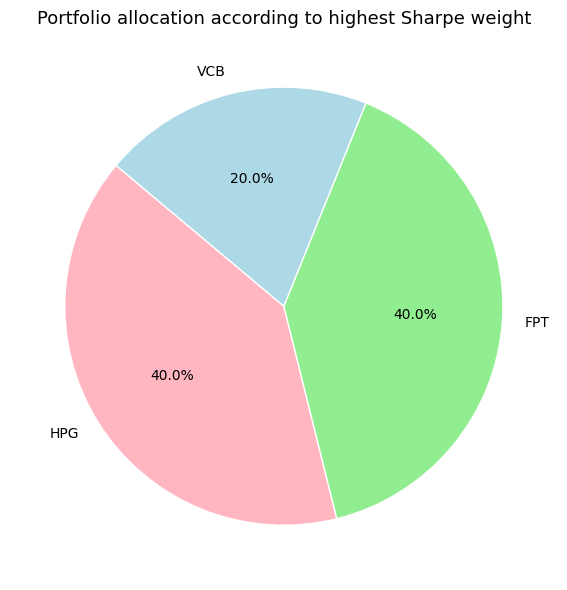

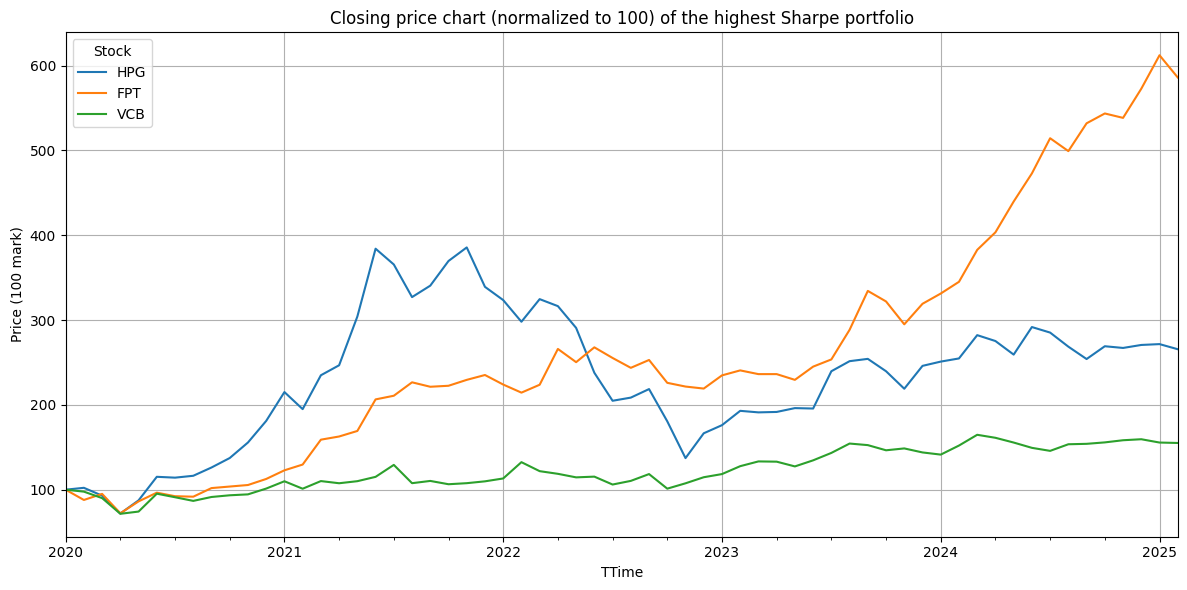

In [ ]:
# Bỏ định dạng % để tìm Sharpe cao nhất
results_raw = pd.DataFrame(results)

# Tìm danh mục có Sharpe cao nhất
best_portfolio = results_raw.loc[results_raw['Sharpe Ratio'].idxmax()]
print("\n Portfolio with highest Sharpe:")
print(best_portfolio)

# Instead of using ast.literal_eval, directly access the 'Weights' dictionary
allocation = best_portfolio['Weights']

# Màu pastel: hồng nhạt, xanh lá nhạt, xanh dương nhạt
pastel_colors = ['#FFB6C1', '#90EE90', '#ADD8E6']

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(
    allocation.values(),
    labels=allocation.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=pastel_colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Portfolio allocation according to highest Sharpe weight", fontsize=13)
plt.tight_layout()
plt.show()

# Define top_stocks based on the keys of the allocation dictionary
top_stocks = list(allocation.keys())  # Assuming 'allocation' is a dictionary

# Chuẩn hóa giá đóng cửa theo mốc 100 ở thời điểm đầu
normalized_prices = monthly_close_df[top_stocks] / monthly_close_df[top_stocks].iloc[0] * 100

# Vẽ biểu đồ normalized
normalized_prices.plot(figsize=(12, 6))
plt.title("Closing price chart (normalized to 100) of the highest Sharpe portfolio")
plt.xlabel("TTime")
plt.ylabel("Price (100 mark)")
plt.legend(title="Stock")
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.4. Vẽ các đồ thị cho tổ hợp Sharpe ratio max

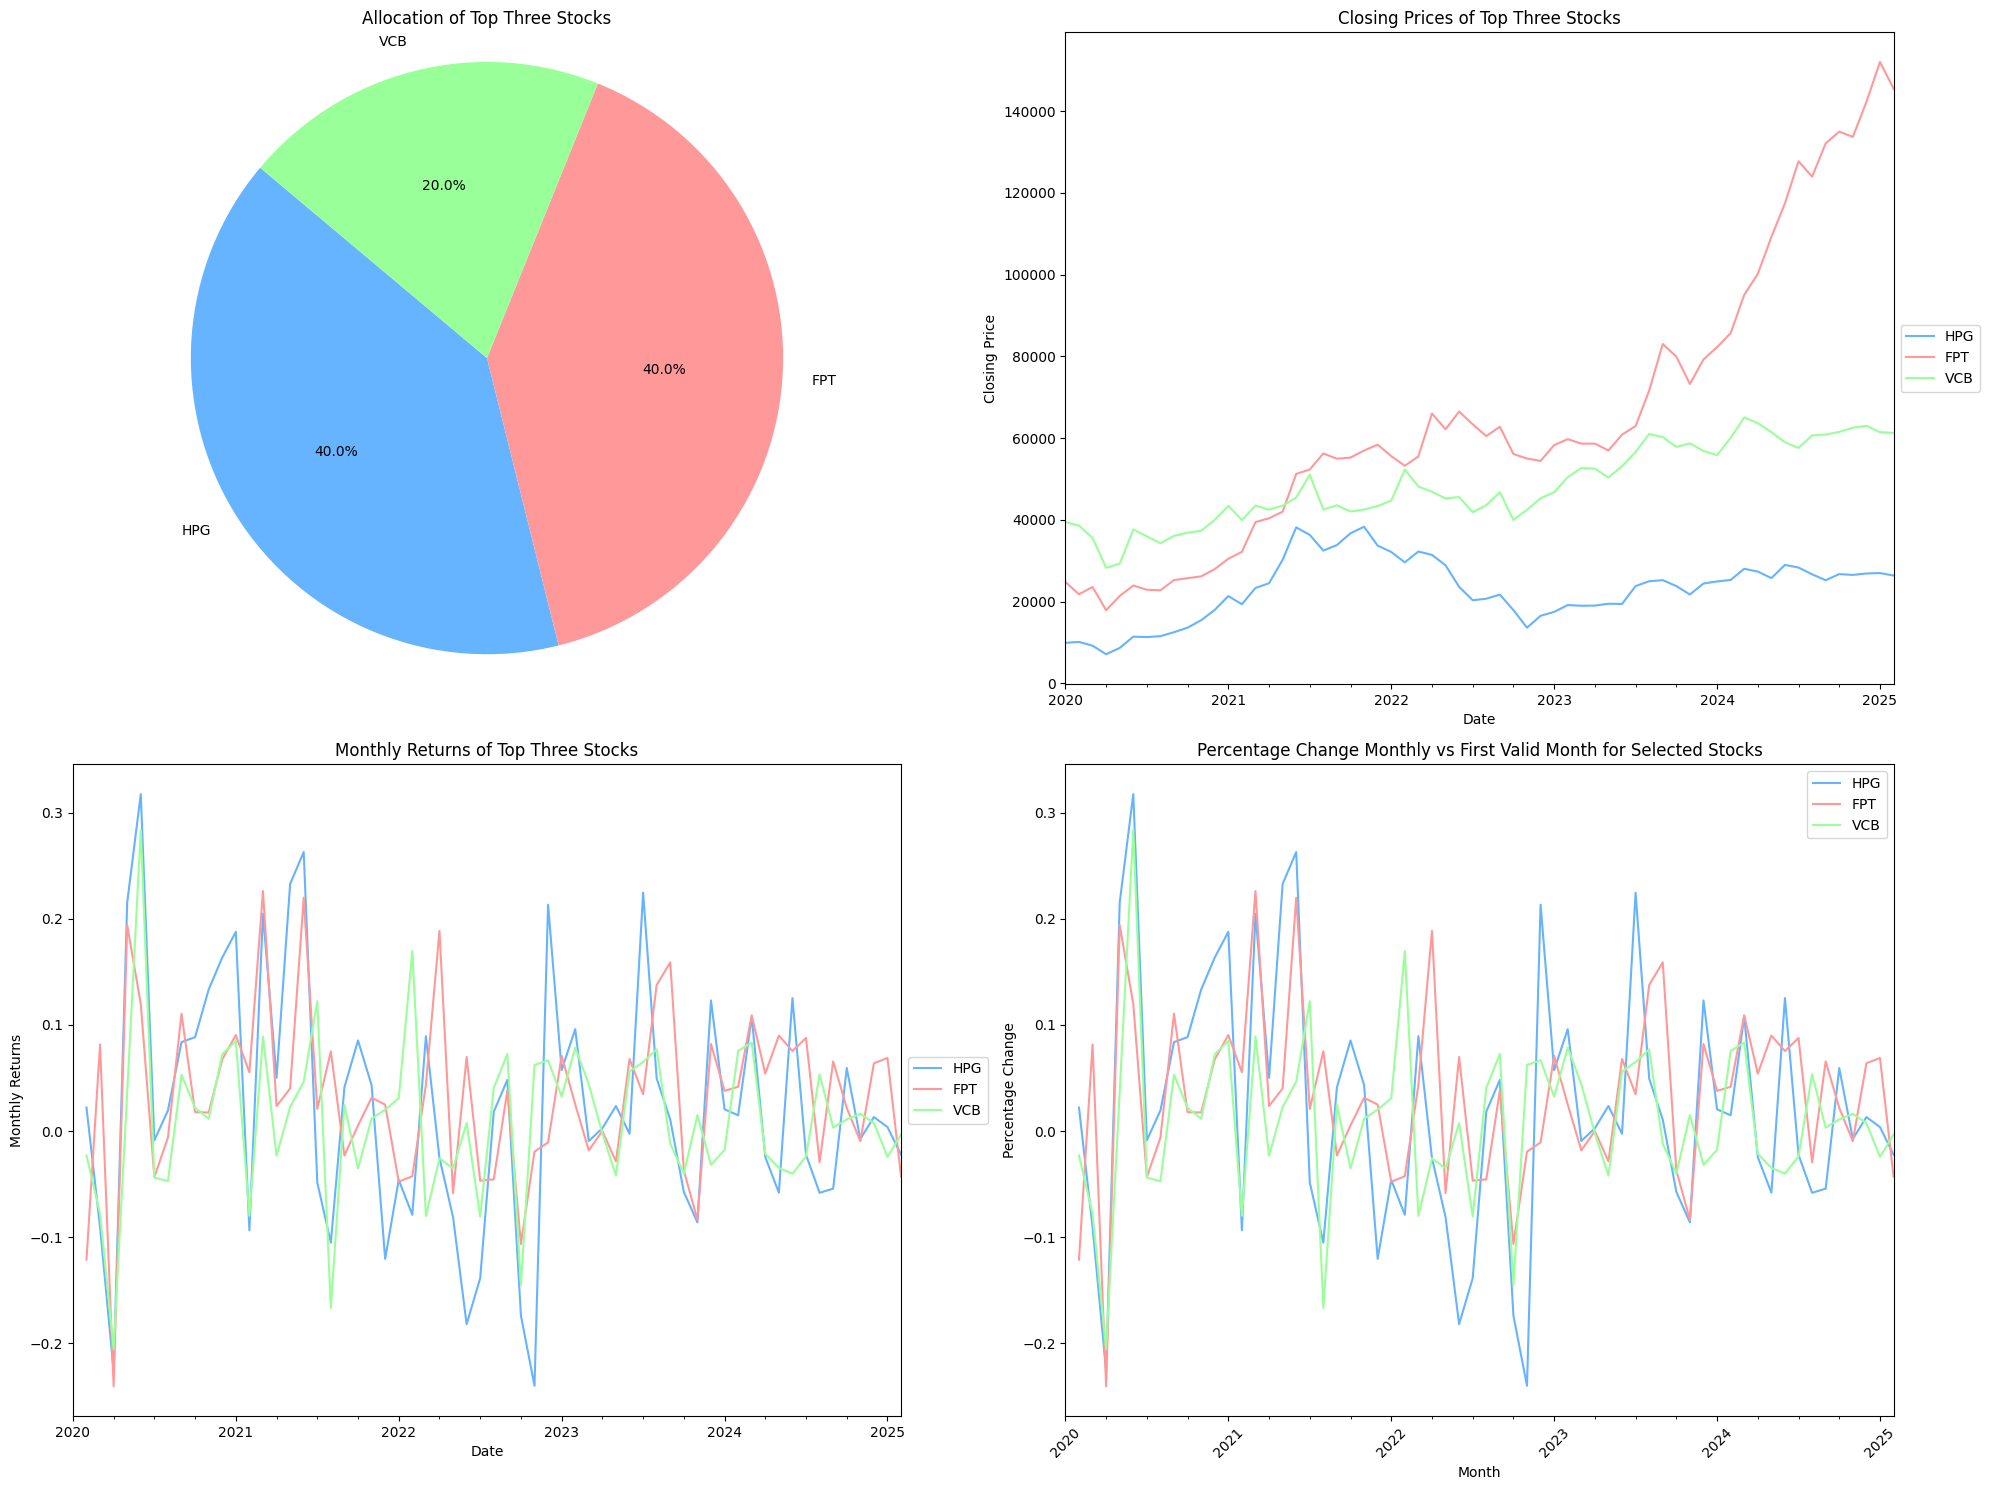

In [ ]:
# Màu sắc tùy chỉnh cho biểu đồ tròn
pie_colors = line_colors = ['#66b3ff','#ff9999', '#99ff99']

# Tạo một hình mới
fig = plt.figure(figsize=(25,20))

# Vẽ biểu đồ tròn
ax1 = fig.add_subplot(2, 2, 1)
# Assuming allocation_percentages and top_three_stocks are defined correctly
ax1.pie(allocation.values(), labels=allocation.keys(), autopct='%1.1f%%', startangle=140, colors=pie_colors) # Replace allocation_percentages and top_three_stocks with allocation.values() and allocation.keys()
ax1.set_title('Allocation of Top Three Stocks')
ax1.axis('equal')  # Đảm bảo tỉ lệ giống nhau để biểu đồ tròn được vẽ như một hình tròn.

# Vẽ biểu đồ giá đóng cửa
ax2 = fig.add_subplot(2, 2, 2)
# Create pivot_df from monthly_close_df
pivot_df = monthly_close_df[top_stocks] # Assuming top_stocks is defined correctly and contains the desired stock tickers

pivot_df.plot(kind='line', figsize=(10, 6), color=line_colors, ax=ax2) # plot using the newly created pivot_df
ax2.set_title('Closing Prices of Top Three Stocks')
ax2.set_xlabel('Date')
ax2.set_ylabel('Closing Price')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(linewidth=1.0)
ax2.grid(False)

# Vẽ biểu đồ lợi nhuận hàng tháng
ax3 = fig.add_subplot(2, 2, 3)
# Assuming monthly_returns_top_three is defined correctly
# monthly_returns_top_three.plot(kind='line', figsize=(10, 6), color=line_colors, ax=ax3) # Assuming monthly_returns_top_three is defined and available. If not, you'll need to define it
pivot_df.pct_change().plot(kind='line', figsize=(10, 6), color=line_colors, ax=ax3)
ax3.set_title('Monthly Returns of Top Three Stocks')
ax3.set_xlabel('Date')
ax3.set_ylabel('Monthly Returns')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax3.grid(linewidth=1.0)
ax3.grid(False)


# Vẽ biểu đồ phần trăm thay đổi hàng tháng cho các cổ phiếu được chọn
ax4 = fig.add_subplot(2, 2, 4)
# Assuming percentage_change_monthly is defined correctly
# for symbol in top_three_stocks:
#     ax4.plot(percentage_change_monthly.index, percentage_change_monthly[symbol], linestyle='-', label=symbol, color=line_colors[top_three_stocks.index(symbol)])
# ax4.set_title('Percentage Change Monthly vs First Valid Month for Selected Stocks')
pivot_df.pct_change().plot(kind='line', figsize=(10, 6), color=line_colors, ax=ax4)
ax4.set_title('Percentage Change Monthly vs First Valid Month for Selected Stocks')
ax4.set_xlabel('Month')
ax4.set_ylabel('Percentage Change')
ax4.legend()
ax4.grid(False)
ax4.tick_params(axis='x', rotation=45)

fig.set_size_inches(20,15)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

## 6.5. Vẽ lợi nhuận hàng tháng của tổ hợp Sharpe cao nhất

Lợi nhuận hàng tháng của danh mục Sharpe cao nhất:
╒═════════════════════╤══════════════════════╕
│ Thời gian           │   Lợi nhuận danh mục │
╞═════════════════════╪══════════════════════╡
│ 2020-02-01 00:00:00 │             -4.4243% │
├─────────────────────┼──────────────────────┤
│ 2020-03-01 00:00:00 │             -1.9186% │
├─────────────────────┼──────────────────────┤
│ 2020-04-01 00:00:00 │            -22.7826% │
├─────────────────────┼──────────────────────┤
│ 2020-05-01 00:00:00 │             17.1187% │
├─────────────────────┼──────────────────────┤
│ 2020-06-01 00:00:00 │             23.1646% │
├─────────────────────┼──────────────────────┤
│ 2020-07-01 00:00:00 │             -2.9623% │
├─────────────────────┼──────────────────────┤
│ 2020-08-01 00:00:00 │             -0.4137% │
├─────────────────────┼──────────────────────┤
│ 2020-09-01 00:00:00 │              8.8400% │
├─────────────────────┼──────────────────────┤
│ 2020-10-01 00:00:00 │              4.6897% │
├────────

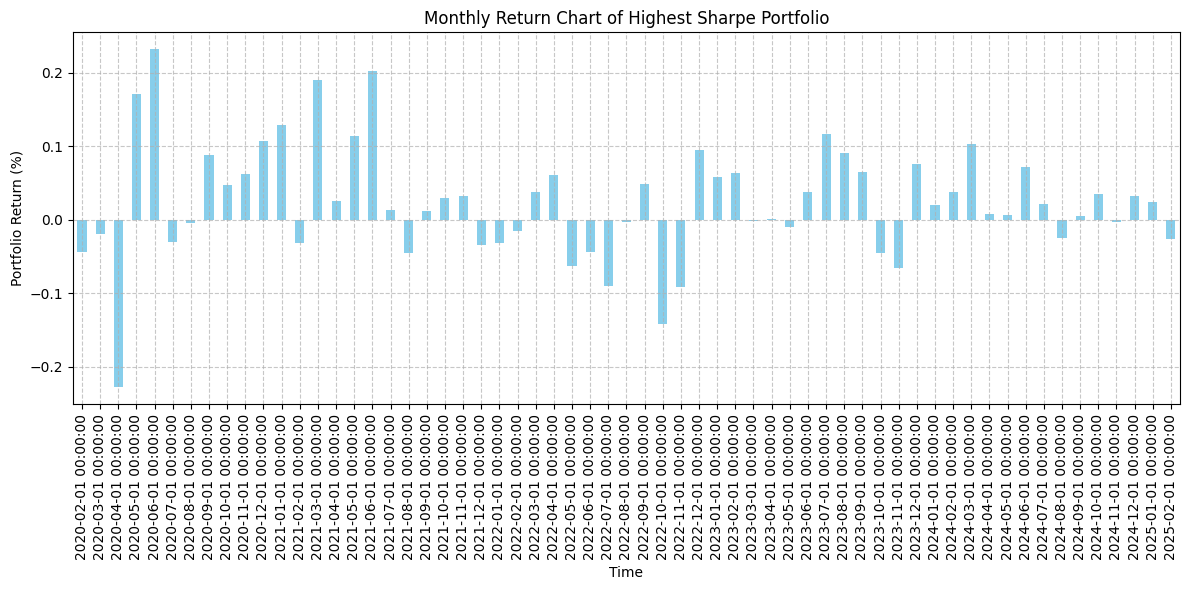

In [ ]:
# Tính lợi nhuận hàng tháng của từng cổ phiếu
monthly_returns = monthly_close_df[top_stocks].pct_change().dropna()

# Lấy trọng số từ danh mục Sharpe cao nhất
# weights = [best_portfolio['wi'], best_portfolio['wj'], best_portfolio['wk']] # This line caused the error.
# Instead, access weights directly
weights = list(best_portfolio['Weights'].values())

# weights = [float(w) if isinstance(w, (int, float)) else float(str(w).strip('%')) / 100 for w in weights] # This line is no longer needed

# Tính lợi nhuận danh mục theo trọng số
portfolio_returns = monthly_returns.dot(weights)

# Chuyển Series thành DataFrame để dễ định dạng
portfolio_returns_df = portfolio_returns.reset_index()
portfolio_returns_df.columns = ['Thời gian', 'Lợi nhuận danh mục']

# In bảng với tabulate
print("Lợi nhuận hàng tháng của danh mục Sharpe cao nhất:")
print(tabulate(portfolio_returns_df, headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".4%"))

# Vẽ biểu đồ lợi nhuận danh mục theo tháng
portfolio_returns.plot(figsize=(12, 6), kind='bar', color='skyblue')
plt.title("Monthly Return Chart of Highest Sharpe Portfolio")
plt.xlabel("Time")
plt.ylabel("Portfolio Return (%)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6.6. Tính lợi nhuận hàng tháng

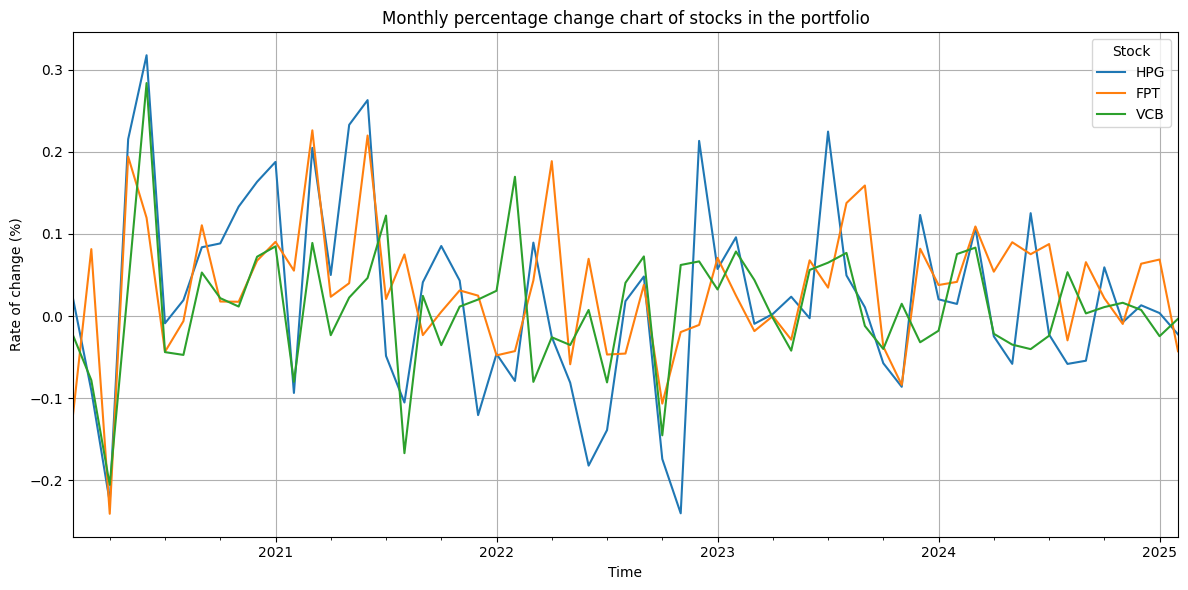

In [ ]:
# Vẽ biểu đồ thay đổi phần trăm theo tháng của từng cổ phiếu
monthly_returns.plot(figsize=(12, 6))
plt.title("Monthly percentage change chart of stocks in the portfolio")
plt.xlabel("Time")
plt.ylabel("Rate of change (%)")
plt.legend(title="Stock")
plt.grid(True)
plt.tight_layout()
plt.show()


# **7. Vẽ đường biên hiệu quả**

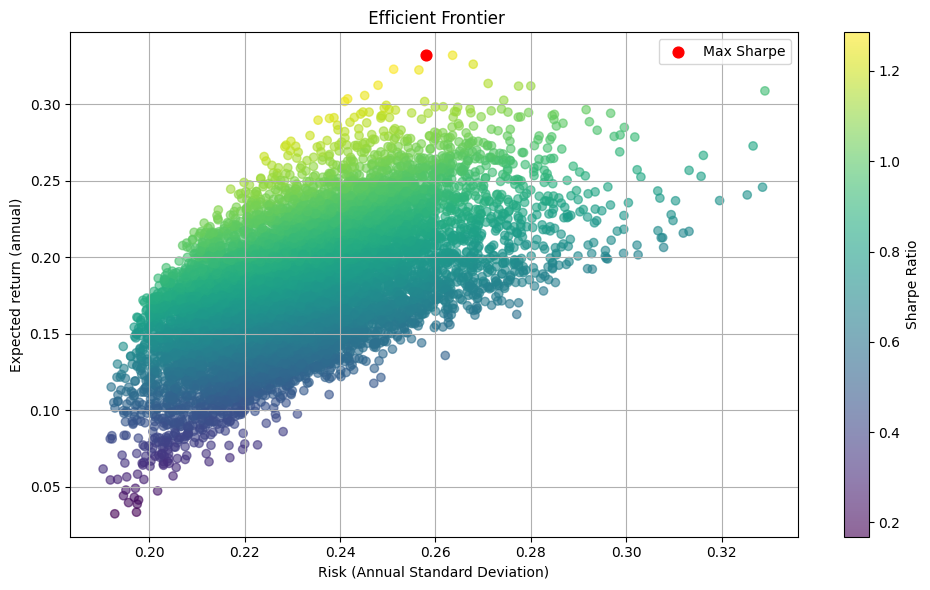

In [ ]:
# Lấy danh sách 3 cổ phiếu có Sharpe Ratio cao nhất
top3_portfolios = results_raw.sort_values(by='Sharpe Ratio', ascending=False).head(3)
top3_stocks = set()

# Tập hợp tên các cổ phiếu trong 3 danh mục có Sharpe cao nhất
for weights_dict in top3_portfolios['Weights']:
    top3_stocks.update(weights_dict.keys())

top3_stocks = list(top3_stocks)

# Tạo ma trận lợi suất hàng tháng (returns) từ giá đóng cửa
returns = monthly_close_df[top3_stocks].pct_change().dropna()

# Khởi tạo các biến
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # rows: returns, volatility, sharpe

weights_record = []

np.random.seed(42)

# Tạo danh mục ngẫu nhiên
for i in range(num_portfolios):
    weights = np.random.random(len(top3_stocks))
    weights /= np.sum(weights)

    # Tính lợi suất kỳ vọng và độ biến động
    expected_return = np.sum(returns.mean() * weights) * 12
    volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))
    sharpe_ratio = expected_return / volatility

    results[0, i] = expected_return
    results[1, i] = volatility
    results[2, i] = sharpe_ratio
    weights_record.append(weights)

# Vẽ đường biên hiệu quả
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Sharpe Ratio')

# Đánh dấu danh mục Sharpe cao nhất
max_sharpe_idx = results[2].argmax()
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], c='red', s=60, label='Max Sharpe')

plt.title(' Efficient Frontier')
plt.xlabel('Risk (Annual Standard Deviation)')
plt.ylabel('Expected return (annual)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **8. Vẽ CAL**

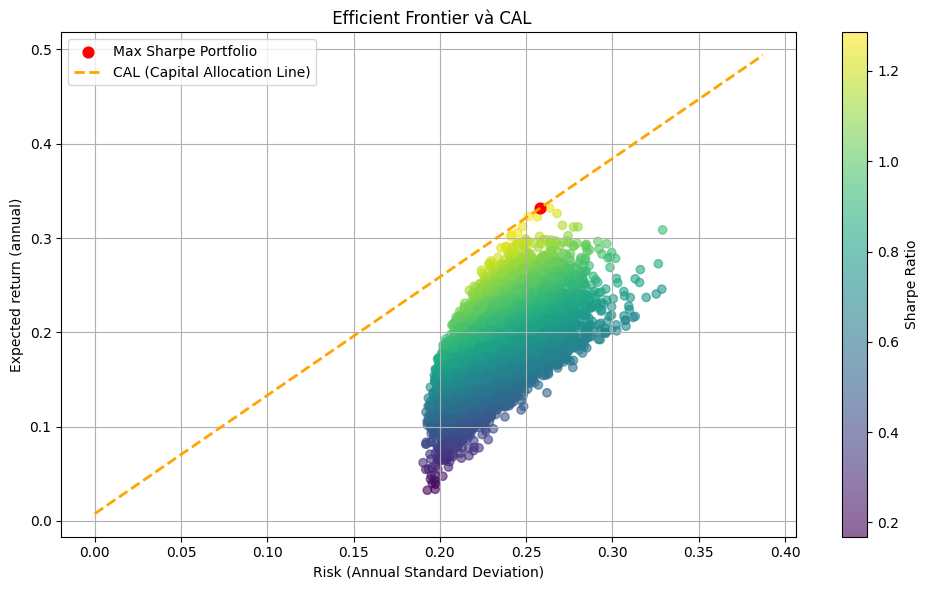

In [ ]:
# Giả định lãi suất phi rủi ro
risk_free_rate = 0.09/12

# Tọa độ điểm danh mục Sharpe cao nhất
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_vol = results[1, max_sharpe_idx]

# Tính slope của CAL
cal_slope = (max_sharpe_return - risk_free_rate) / max_sharpe_vol

# Tạo dữ liệu đường CAL (từ 0 đến mức rủi ro của danh mục Sharpe tối đa)
cal_x = np.linspace(0, max_sharpe_vol * 1.5, 100)
cal_y = risk_free_rate + cal_slope * cal_x

# Vẽ lại biểu đồ Efficient Frontier kèm đường CAL
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Sharpe Ratio')

# Đánh dấu điểm Sharpe tối đa
plt.scatter(max_sharpe_vol, max_sharpe_return, c='red', s=60, label='Max Sharpe Portfolio')

# Vẽ đường CAL
plt.plot(cal_x, cal_y, color='orange', linestyle='--', linewidth=2, label='CAL (Capital Allocation Line)')

# Giao diện chung
plt.title(' Efficient Frontier và CAL')
plt.xlabel('Risk (Annual Standard Deviation)')
plt.ylabel('Expected return (annual)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **9. Phân bổ đầu tư**

## 9.1. tính hệ số A

In [ ]:
import numpy as np
from scipy.stats import norm

# Mức tin cậy của VaR
alpha = 0.95
z_1_alpha = norm.ppf(alpha)

# Lãi suất phi rủi ro đã có
risk_free_rate = 0.09 / 12  # 9% hàng năm chia cho 12 tháng

# Lấy danh mục GMV (Global Minimum Variance Portfolio)
idx_GMV = results[1].argmin()  # Tìm danh mục có độ lệch chuẩn thấp nhất
R_GMV = results[0, idx_GMV]  # Lợi suất danh mục GMV
V_GMV = results[1, idx_GMV] ** 2  # Phương sai danh mục GMV

# Tính độ dốc s của đường biên hiệu quả
s = (max_sharpe_return - R_GMV) / (max_sharpe_vol ** 2 - V_GMV)

# Đảm bảo s không khiến biểu thức bên trong căn bậc hai âm
s = min(s, max(0, z_1_alpha**2 * 0.9))

# Tính hệ số ngại rủi ro theo Exponential Utility
if (z_1_alpha**2 - s) > 0:
    gamma_exp = np.sqrt(z_1_alpha**2 - s) / np.sqrt(V_GMV)
else:
    gamma_exp = np.nan  # Tránh lỗi tính toán

# Tính hệ số ngại rủi ro theo Quadratic Utility
if (z_1_alpha**2 - s) > 0:
    gamma_quad = 1 / (1 + R_GMV + (1 + s) * np.sqrt(V_GMV) / np.sqrt(z_1_alpha**2 - s))
else:
    gamma_quad = np.nan  # Tránh lỗi tính toán

# Kết quả
print(f"Hệ số ngại rủi ro (Exponential Utility): {gamma_exp:.2f}")
print(f"Hệ số ngại rủi ro (Quadratic Utility): {gamma_quad:.2f}")


Hệ số ngại rủi ro (Exponential Utility): 2.73
Hệ số ngại rủi ro (Quadratic Utility): 0.43


In [ ]:
risk_free_rate = 0.09 / 12

max_sharpe = results_raw.loc[results_raw['Sharpe Ratio'].idxmax()]

# Access the values using the correct keys
rp = max_sharpe['Mean Return']
sigma_p = max_sharpe['Volatility']

# Tính hệ số ngại rủi ro A
A = (rp - risk_free_rate) / (sigma_p ** 2)

# In kết quả
print(f"Hệ số ngại rủi ro (A): {A:.4f}")

Hệ số ngại rủi ro (A): 2.7004


## 9.2 Phân bổ vốn


 Optimal Complete Portfolio
A: 3
╒═══════════════════════════════════════╤════════════╕
│ Thông tin                             │    Giá trị │
╞═══════════════════════════════════════╪════════════╡
│ A                                     │ 3          │
├───────────────────────────────────────┼────────────┤
│ Erc (Return of complete portfolio)    │ 0.0225195  │
├───────────────────────────────────────┼────────────┤
│ Varc (Variance of complete portfolio) │ 0.00500649 │
├───────────────────────────────────────┼────────────┤
│ U (Utility)                           │ 0.0150097  │
├───────────────────────────────────────┼────────────┤
│ HPG                                   │ 0.360058   │
├───────────────────────────────────────┼────────────┤
│ FPT                                   │ 0.360058   │
├───────────────────────────────────────┼────────────┤
│ VCB                                   │ 0.180029   │
├───────────────────────────────────────┼────────────┤
│ T-Bills                      

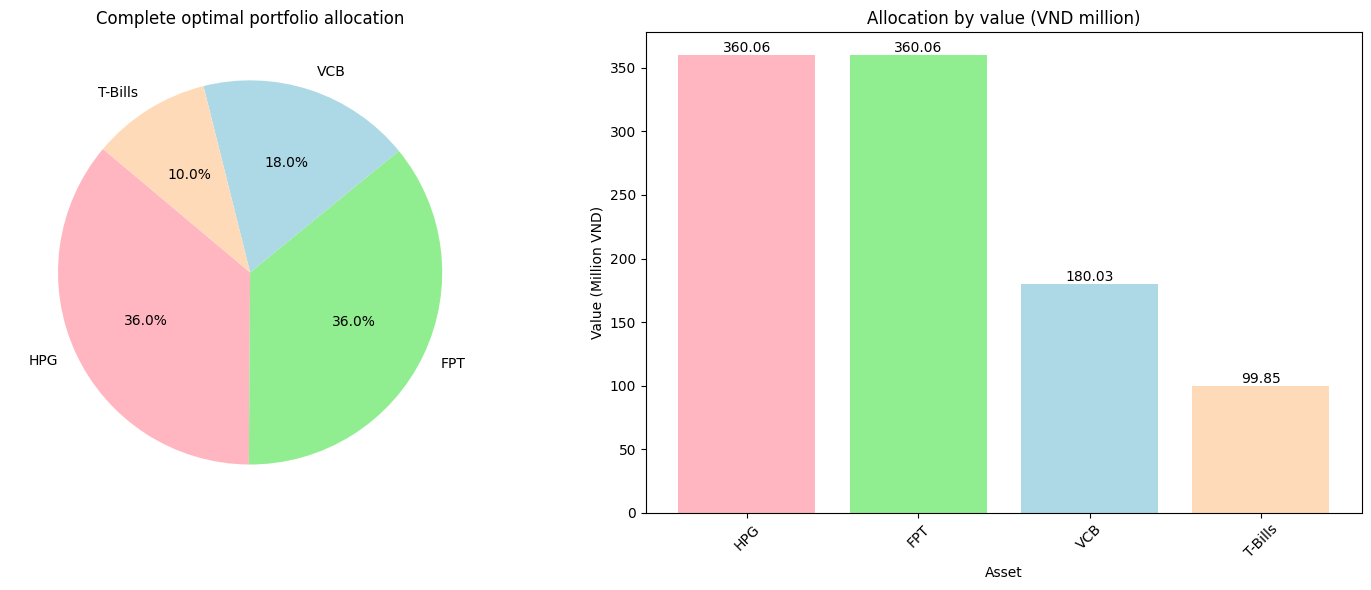

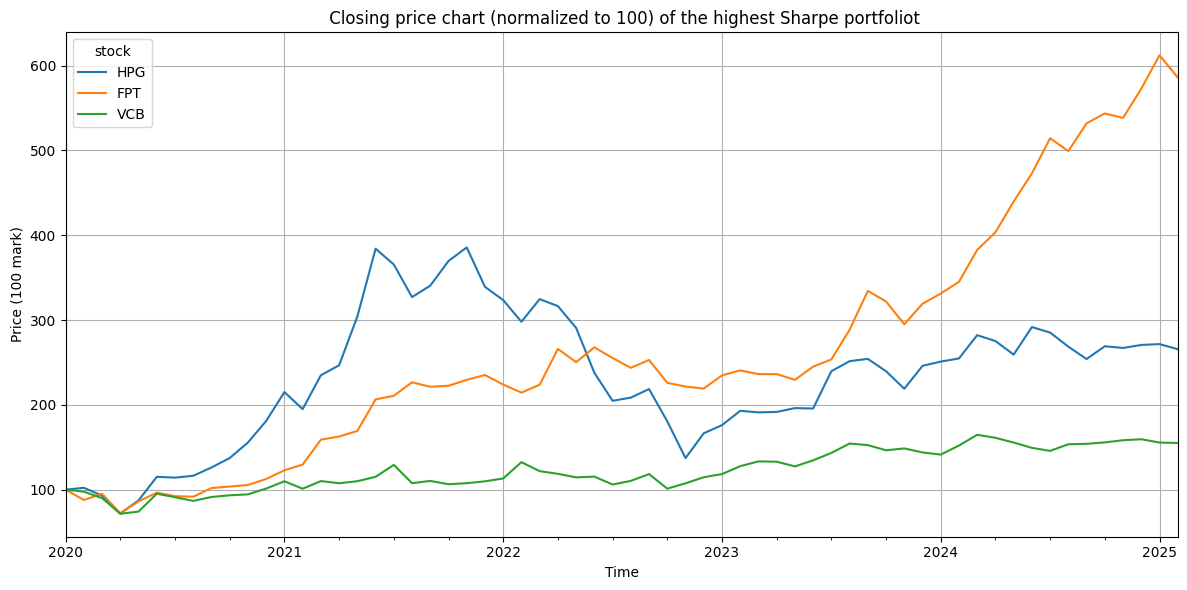

In [ ]:
#  Tính toán A, Erc, Varc, U
print('\n Optimal Complete Portfolio')
A = 3
print('A:', A)

max_sharpe_port = {
    'Mean Return': best_portfolio['Mean Return'],
    'Volatility': best_portfolio['Volatility'],
    'Weights': best_portfolio['Weights']
}

rf = 0.09/12 # Lãi suất phi rủi ro

# Tính toán theo công thức portfolio hoàn chỉnh
y = (max_sharpe_port['Mean Return'] - rf) / (A * (max_sharpe_port['Volatility']) ** 2)
y = min(y, 1.0)  # Giới hạn y ≤ 1 để không có phần âm
Erc = rf + y * (max_sharpe_port['Mean Return'] - rf)
varc = ((max_sharpe_port['Volatility']) * y) ** 2
allocation_risky_assets = {asset: y * weight for asset, weight in max_sharpe_port['Weights'].items()}
allocation_risk_free_asset = 1 - y
U = Erc - (A * varc) / 2

#  In thông tin danh mục
additional_info = [['A', A],
                   ['Erc (Return of complete portfolio)', Erc],
                   ['Varc (Variance of complete portfolio)', varc],
                   ['U (Utility)', U]]

# Dữ liệu cổ phiếu rủi ro
risky_assets_data = [[asset, weight] for asset, weight in allocation_risky_assets.items()]
risk_free_asset_data = [['T-Bills', allocation_risk_free_asset]]

# Tổng hợp
portfolio_data = additional_info + risky_assets_data + risk_free_asset_data

# Hiển thị bảng
print(tabulate(portfolio_data, headers=['Thông tin', 'Giá trị'], tablefmt='fancy_grid', showindex=False))

#  Biểu đồ tròn và cột theo tỷ trọng và giá trị
risky_assets = list(allocation_risky_assets.keys())
allocation_values = list(allocation_risky_assets.values())
risky_assets.append('T-Bills')
allocation_values.append(allocation_risk_free_asset)

#tổng đầu tư 1000 triệu VND
allocation_risky_assets_vnd = {asset: value * 1000 for asset, value in allocation_risky_assets.items()}
allocation_risk_free_asset_vnd = allocation_risk_free_asset * 1000

risky_assets_vnd = list(allocation_risky_assets_vnd.keys())
asset_values_vnd = list(allocation_risky_assets_vnd.values())
risky_assets_vnd.append('T-Bills')
asset_values_vnd.append(allocation_risk_free_asset_vnd)

# Màu
colors = ['#FFB6C1', '#90EE90', '#ADD8E6', '#FFDAB9']

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ tròn tỷ trọng
ax1.pie(allocation_values, labels=risky_assets, colors=colors, autopct='%1.1f%%', startangle=140)
ax1.set_title('Complete optimal portfolio allocation')

# Biểu đồ cột giá trị
ax2.bar(risky_assets_vnd, asset_values_vnd, color=colors)
ax2.set_title('Allocation by value (VND million)')
ax2.set_xlabel('Asset')
ax2.set_ylabel('Value (Million VND)')

# Hiển thị số liệu trên cột
for i, value in enumerate(asset_values_vnd):
    ax2.text(i, value, f'{value:.2f}', ha='center', va='bottom')

ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Biểu đồ chuẩn hóa giá đóng cửa
# Nếu chưa có normalized_prices thì tính:
normalized_prices = monthly_close_df[top_stocks] / monthly_close_df[top_stocks].iloc[0] * 100

normalized_prices.plot(figsize=(12, 6))
plt.title(" Closing price chart (normalized to 100) of the highest Sharpe portfoliot")
plt.xlabel("Time")
plt.ylabel("Price (100 mark)")
plt.legend(title="stock")
plt.grid(True)
plt.tight_layout()
plt.show()

Optimal Complete Portfolio
╒═════════╤════════════╕
│ Info    │      Value │
╞═════════╪════════════╡
│ A       │ 3          │
├─────────┼────────────┤
│ Erc     │ 0.0225195  │
├─────────┼────────────┤
│ Varc    │ 0.00500649 │
├─────────┼────────────┤
│ U       │ 0.0150097  │
├─────────┼────────────┤
│ HPG     │ 0.360058   │
├─────────┼────────────┤
│ FPT     │ 0.360058   │
├─────────┼────────────┤
│ VCB     │ 0.180029   │
├─────────┼────────────┤
│ T-Bills │ 0.0998549  │
╘═════════╧════════════╛


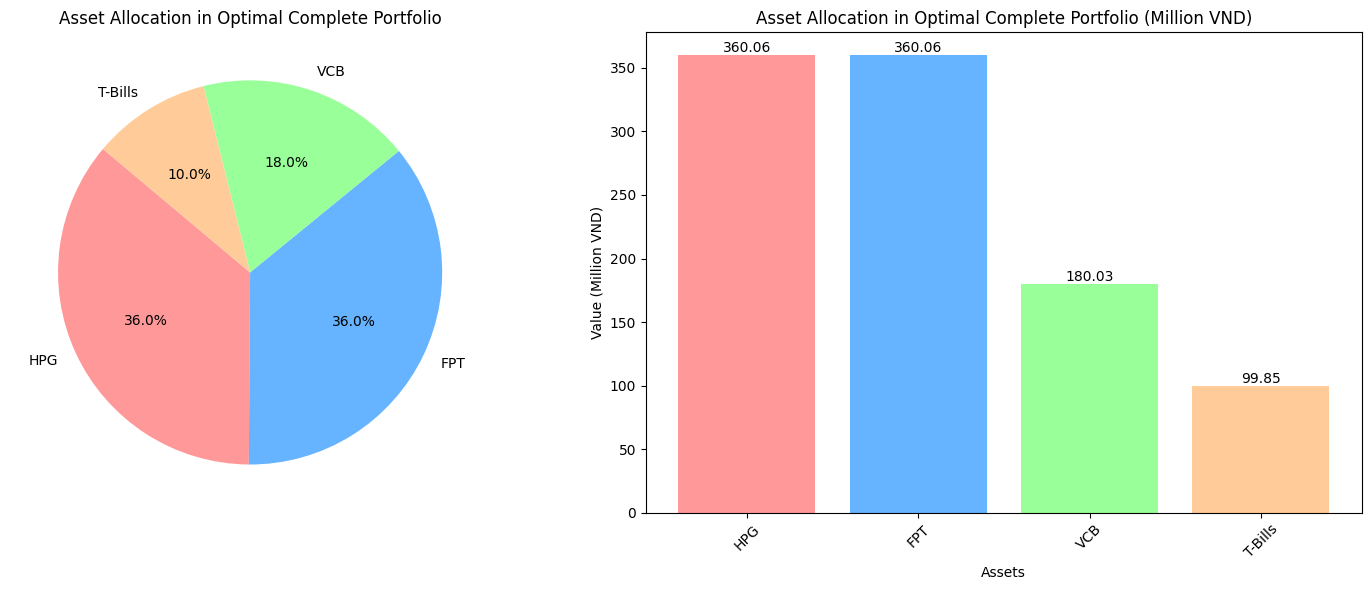

In [ ]:
# Calculate information A, Erc, and Varc
print('Optimal Complete Portfolio')
rf = 0.09 / 12
A = 3

# Define max_sharpe_port using correct keys from best_portfolio
max_sharpe_port = {
    'Mean Return': best_portfolio['Mean Return'],  # Use 'Mean Return' instead of 'E(rp)'
    'Volatility': best_portfolio['Volatility'],  # Use 'Volatility' instead of 'σp'
    'Weights': best_portfolio['Weights']  # Access 'Weights' directly
}

y = (max_sharpe_port['Mean Return'] - rf) / (A * (max_sharpe_port['Volatility']) ** 2)
Erc = rf + y * (max_sharpe_port['Mean Return'] - rf)
varc = ((max_sharpe_port['Volatility']) * y) ** 2
allocation_risky_assets = {asset: y * weight for asset, weight in max_sharpe_port['Weights'].items()}

# Ensure allocation_risk_free_asset is non-negative
allocation_risk_free_asset = max(0, 1 - y)  # Use max(0, 1 - y) to ensure it's non-negative

U = Erc - (A * varc) / 2

# Add information about A, Erc, and Varc
additional_info = [['A', A],
                   ['Erc', Erc],
                   ['Varc', varc],
                   ['U', U]]

# Data of risky assets
risky_assets_data = []
for asset, weight in allocation_risky_assets.items():
    risky_assets_data.append([asset, weight])

# Data of risk-free asset
risk_free_asset_data = [['T-Bills', allocation_risk_free_asset]]

# Create a summary data list
portfolio_data = additional_info + risky_assets_data + risk_free_asset_data

# Display the result table using fancy_grid
print(tabulate(portfolio_data, headers=['Info', 'Value'], tablefmt='fancy_grid', showindex=False))

# Names of risky assets
risky_assets = list(allocation_risky_assets.keys())

# Allocation of risky assets
allocation_values = list(allocation_risky_assets.values())
risky_assets.append('T-Bills')
allocation_values.append(allocation_risk_free_asset)

# Calculate allocation in cash
allocation_risky_assets_vnd = {asset: value * 1000 for asset, value in allocation_risky_assets.items()}
allocation_risk_free_asset_vnd = allocation_risk_free_asset * 1000

# Names of risky assets
risky_assets_vnd = list(allocation_risky_assets_vnd.keys())

# Values of risky assets
asset_values_vnd = list(allocation_risky_assets_vnd.values())

# Add risk-free asset to the list
risky_assets_vnd.append('T-Bills')
asset_values_vnd.append(allocation_risk_free_asset_vnd)

# Define colors for the pie chart
pie_colors =bar_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot pie chart on the first subplot
ax1.pie(allocation_values, labels=risky_assets, colors=pie_colors, autopct='%1.1f%%', startangle=140)
ax1.set_title('Asset Allocation in Optimal Complete Portfolio')

# Plot bar chart on the second subplot
ax2.bar(risky_assets_vnd, asset_values_vnd, color=bar_colors)
ax2.set_title('Asset Allocation in Optimal Complete Portfolio (Million VND)')
ax2.set_xlabel('Assets')
ax2.set_ylabel('Value (Million VND)')

# Display values on each column of the bar chart
for i, value in enumerate(asset_values_vnd):
    ax2.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Rotate x-axis labels of the bar chart for better readability
ax2.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()